<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/statistical_tests_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Various statistical tests from scratch

References

1. https://www.scribbr.com/statistics/t-test/
2. https://www.statisticshowto.com/probability-and-statistics/t-test/
3. https://en.wikipedia.org/wiki/Student%27s_t-test
4. https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.stats import (
    t,
    ttest_ind, ttest_rel, ttest_1samp,
    uniform, chi2, expon, lognorm, norm
)

In [2]:
alpha = 0.05 # significance level

In [3]:
# Load data
data = load_iris(as_frame=True)
df = data['data']
df['specie'] = list(map(lambda x: data['target_names'][x], data['target']))
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),specie
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
df['specie'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: specie, dtype: int64

## 1. T-test (Student's T-test)

### 1.1. Two sample T-test

Let's imagine we want to know whether the mean petal length of iris flowers differs according to their species. We're going to pick 50 petals length of versicolor and virginica species. Then we want to test the difference between these two groups using a T-test and null and alterative hypotheses.

**H0**: the true difference between these group means is zero.

**H1**: the true difference is different from zero.

The formulas for the $ t $ are:

1. In the case of equal sample sizes and variance:

$ t = \frac{\bar{x_1} - \bar{x_2}}{s \sqrt{\frac{2}{n}}} $

2. In the case of equal or unequal sample sizes and similar variances ($ \frac{1}{2} < \frac{s_{x_1}}{s_{x_2}} < 2 $):

$ t = \frac{\bar{x_1} - \bar{x_2}}{s_p \sqrt{\frac{1}{n_1} + \frac{1}{n_1}}} $,

where $ s_p = \sqrt{ \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2} } $ is the pooled standard deviation

3. In the case of equal or unequal sample sizes and unequal variances ($
 s_{x_1} > 2s_{x_2} or s_{x_2} > 2s_{x_1} $ ) (Welch's t-test):

$ t = \frac{\bar{x_1} - \bar{x_2}}{s_\bar\Delta} $,

where $ s_\bar\Delta = \sqrt{(\frac{s_1}{\sqrt{n_1}})^2 + (\frac{s_2}{\sqrt{n_2}})^2} $

In [ ]:
g1 = df.loc[df['specie'] == 'versicolor']['petal length (cm)'].to_numpy()
g2 = df.loc[df['specie'] == 'virginica']['petal length (cm)'].to_numpy()

In [ ]:
s1, s2 = np.std(g1), np.std(g2)
1/2 < s1/s2 < 2

True

**Conclusion:** Hence, we have case of equal sample sizes and similar variances (#2)

In [ ]:
n1, n2 = len(g1), len(g2)
mean1, mean2 = np.mean(g1), np.mean(g2)

In [ ]:
s_p = np.sqrt(( (n1-1)*s1**2 + (n2-1)*s2**2 )/(n1 + n2 -2)) # calculate the pooled standard deviation
print(f"The pooled standard deviation:  {s_p}")

The pooled standard deviation:  0.5073933385451567


In [ ]:
t_scratch = (mean1 - mean2) / (s_p * np.sqrt(1/n1 + 1/n2))
print(f"Two sample T-test: {t_scratch}")

Two sample T-test: -12.731739873689888


In [ ]:
cv = t.ppf(alpha/2, n1 + n2 - 2) # calculate the critical value for the two-tailed test
print(f"The confidence interval (CI) for DOF (degree if freedom) of {n1+n2-2} and significant level of {alpha}:\n"
      f"from {cv:.2f} to {-cv:.2f}")

The confidence interval (CI) for DOF (degree if freedom) of 98 and significant level of 0.05:
from -1.98 to 1.98


In [ ]:
t_scratch < cv

True

In [ ]:
p_value = t.cdf(t_scratch, n1 + n2 -2)*2 # let's calculate p-value for the obtained T-test value
print(f"The probability of obtaining T-test results of {t_scratch} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value}")

The probability of obtaining T-test results of -12.731739873689888 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 1.7129346742281333e-22


**Conclusion:** The value of T-test is outside of the 95% CI, p-value is less then 0.025 therefore we can reject HO => the true difference is different from zero.

In [ ]:
# Let's use a function from scipy library

In [ ]:
t_scipy = ttest_ind(g1, g2, equal_var=False)
t_scipy

Ttest_indResult(statistic=-12.603779441384987, pvalue=4.900287527398095e-22)

**Conclusion:** The result of the T-test obtained by in-built function differs from implementation from scratch. It looks a bit wired.  

### 1.2. Paired T-test

Let's assume we want to enlarge the petals of the iris specie of 'setosa'. We invented some treatment and applied it to irises and we want to figure out if our treatment is working or not. So, we have two group of the petal lengths: the first one is the petal lengths before applying the treatment and the other one is after.

**H0**: the second group mean isn't greater then the first group mean

**H1**: the second group mean is greater then the first group mean

$ t = \frac{\bar{X_D}}{s_D/\sqrt{n}} $,

where $ \bar{X_D} $ and $ s_D $ are the average and standard deviation of the differences between all pairs.

In [ ]:
g1 = df.loc[df['specie'] == 'setosa']['petal length (cm)'].to_numpy()
g2 = g1 + np.random.normal(loc=1, scale=1, size=len(g1))

In [ ]:
n = len(g1)
D = g2 - g1
X_D, s_D = np.mean(D), np.std(D)
print(f"The mean and standard deviation of the differences: {X_D}, {s_D}")

The mean and standard deviation of the differences: 1.0310869241155272, 0.8729315964016187


In [ ]:
t_scratch = X_D/(s_D / np.sqrt(n))
print(f"Paired T-test: {t_scratch}")

Paired T-test: 8.352184283858012


In [ ]:
cv = t.ppf(1-alpha, n - 1) # calculate the critical values for the right-tailed test
print(f"A confidence interval (CI) for DOF (degree if freedom) of {n-1} and significant level of {alpha}:\n"
      f"from -inf to {cv}\n")

A confidence interval (CI) for DOF (degree if freedom) of 49 and significant level of 0.05:
from -inf to 1.6765508919142629



In [ ]:
t_scratch > cv

True

In [ ]:
p_value = 1 - t.cdf(t_scratch, n - 1) # let's calculate p-value for the obtained T-test value
print(f"The probability of obtaining T-test results of {t_scratch} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value}")

The probability of obtaining T-test results of 8.352184283858012 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 2.7784885503479018e-11


**Conclusion:** The value of T-test is outside of the 95% CI, p-value is less then 0.05 therefore we can reject HO => the second group mean is greater then the first group mean

In [ ]:
# Let's use a function from scipy library

In [ ]:
t_scipy = ttest_rel(g2, g1, alternative='greater')
t_scipy

TtestResult(statistic=8.26824060276999, pvalue=3.7261151173334626e-11, df=49)

**Conclusion:** The result of the T-test obtained by in-built function differs from implementation from scratch as in the case of two sample T-test. It also looks wired.  

### 1.3. One-sample T-test

Presume we read somewhere that the average petal length of the iris specie of 'setosa' is 1.5 cm (it's imagined data). Let's check if the petal lengths of our irises are according to the population average.

**H0**: The mean of our irises' petal lengths equals the population mean.

**H1**: The mean of our irises' petal lengths doesn't equal the population mean.

$ t = \frac{\bar{X} - \mu}{s/\sqrt{n}} $,

where $ \bar{X} $ and $ s $ are the average and standard deviation of the sample and $ \mu $ - the population mean.

In [ ]:
g1 = df.loc[df['specie'] == 'setosa']['petal length (cm)'].to_numpy()
n = len(g1)

In [ ]:
mu = 1.5
DOF = n - 1 # degrees of freedom

In [ ]:
t_scratch = (np.mean(g1) - mu)/(np.std(g1)/np.sqrt(n))
print(f"Paired T-test: {t_scratch}")

Paired T-test: -1.5629524652770583


In [ ]:
cv = t.ppf(alpha/2, DOF) # calculate the critical values for the two-tailed test
print(f"The confidence interval (CI) for DOF (degree if freedom) of {DOF} and significant level of {alpha}:\n"
      f"from {cv} to {-cv}")

The confidence interval (CI) for DOF (degree if freedom) of 49 and significant level of 0.05:
from -2.0095752344892093 to 2.0095752344892093


In [ ]:
t_scratch < cv or t_scratch > -cv  # the t statistic is outside of the CIs

False

In [ ]:
p_value = t.pdf(t_scratch, n-1)*2 # let's calculate p-value for the obtained T-test value
print(f"The probability of obtaining T-test results of {t_scratch} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value:.2}")

The probability of obtaining T-test results of -1.5629524652770583 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 0.24


**Conclusion:** The value of T-test is inside of the 95% CI, p-value is greater then 0.05 therefore we cann't reject HO => The mean of our irises' petal lengths equals the population mean..

## 2. Z-test

### 2.1. One-sample Z-test

Presume we read somewhere that the average petal length of the iris specie of 'setosa' is 1.5 cm and standard deviation is 0.2 cm (it's imagined data). Let's check if the petal lengths of our irises are according to the population average.

**H0**: The mean of our irises' petal lengths equals the population mean.

**H1**: The mean of our irises' petal lengths doesn't equal the population mean.

$ Z = \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} $,

where $ \bar{X} $ is the average of the sample, $ \mu $ and $ \sigma $ - the population mean and standard deviation.

In [ ]:
g1 = df.loc[df['specie'] == 'setosa']['petal length (cm)'].to_numpy()
n = len(g1)

In [ ]:
mu = 1.5
sigma = 0.2

In [ ]:
Z_scratch = (np.mean(g1) - mu)/(sigma/np.sqrt(n))
print(f"One sample Z-test: {Z_scratch}")

One sample Z-test: -1.3435028842544336


In [ ]:
cv = norm.ppf(alpha/2) # calculate the critical values for the two-tailed test
print(f"The confidence interval (CI) for the significant level of {alpha}:\n"
      f"from {cv:.2f} to {-cv:.2f}")

The confidence interval (CI) for the significant level of 0.05:
from -1.96 to 1.96


In [ ]:
Z_scratch < cv or Z_scratch > -cv  # is z-statistic outside of the CIs

False

In [ ]:
p_value = norm.pdf(Z_scratch)*2 # let's calculate p-value for the obtained Z-test value
print(f"The probability of obtaining Z-test results of {Z_scratch} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value:.2}")

The probability of obtaining T-test results of -1.3435028842544336 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 0.32


**Conclusion**: The value of Z-test is inside of the 95% CI, p-value is greater then 0.05 therefore we cann't reject HO => The mean of our irises' petal lengths equals the population mean..

### 2.2. One-sample proportion Z-test

We've read research that claims that 50% of 'setosa' irises have a sepal length greater than 5 cm. We decided to check it.

**H0**: The sample proportion is equal to the population proportion.

**H1**: The sample proportion is not equal to the population proportion.

$ Z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}} $,

where $ \hat{p} $ is the sample proportion, $ p_0 $ is the population proportion, and $ n $ is the sample size.

Significance level is 5%

In [ ]:
setosa_df = df[df['specie'] == 'setosa']
p_hat = (setosa_df['sepal length (cm)']>5).mean()
n = len(setosa_df)
p0 = .5

In [ ]:
print(f"The sample proportion (p_hat) = {p_hat}\nThe population proportion (p_0) = {p0}\nThe sample size (n) = {n}")

The sample proportion (p_hat) = 0.44
The population proportion (p_0) = 0.5
The sample size (n) = 50


In [ ]:
Z_scratch = (p_hat - p0) / (np.sqrt(p0*(1-p0)/n))
print(f"One sample Z-test: {Z_scratch}")

One sample Z-test: -0.848528137423857


In [ ]:
cv = norm.ppf(alpha/2) # calculate the critical values for the two-tailed test
print(f"The confidence interval (CI) for the significant level of {alpha}:\n"
      f"from {cv:.2f} to {-cv:.2f}")

The confidence interval (CI) for the significant level of 0.05:
from -1.96 to 1.96


In [ ]:
Z_scratch < cv or Z_scratch > -cv  # is z-statistic outside of the CIs

False

In [ ]:
p_value = norm.pdf(Z_scratch)*2 # let's calculate p-value for the obtained Z-test value
print(f"The probability of obtaining Z-test results of {Z_scratch} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value:.2}")

The probability of obtaining Z-test results of -0.848528137423857 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 0.56


**Conclusion**: The value of Z-test is inside of the 95% CI, p-value is greater then 0.05 therefore we fail to reject the $ H_0 $.

### 2.3. Two-sample proportion Z-test

Let's assume we've split our irises of 'setosa' species to the two groups. For the first group, we used a fertilizer that increases a sepal length, and for the second one not. Now we want to compare the proportions of irises with sepal lengths greater than 5 cm in these two groups. We're going to use pooled and unpooled two-sample proportion Z-test.

**H0**: The proportion in group #1 is equal to the proportion in group #2.

**H1**: The proportion in group #1 is not equal to the proportion in group #2.

Pooled two-sample proportion Z-test

$
Z = \frac{\hat{p_1} - \hat{p_2}}{\sqrt{p_0(1-p_0)(\frac{1}{n_1}+\frac{1}{n_2})}}
$,

$
p_0 = \frac{x_1 + x_2}{n_1 + n_2}
$,

where $ \hat{p_1} $ is the sample #1 proportion, $ \hat{p_2} $ is the sample #2 proportion, $ p_0 $ is the pooled proportion, $ n_1 $ is the sample #1 size, $ n_2 $ is the sample #2 size, $ x_1 $ is the number of "success" in the sample #1, $ x_2 $ is the number of "success" in the sample #2.

Unpooled two-sample proportion Z-test

$
Z = \frac{\hat{p_1} - \hat{p_2}}{\sqrt{\frac{\hat{p_1}(1-\hat{p_1})}{n_1} + \frac{\hat{p_2}(1-\hat{p_2})}{n_2} }}
$

Significance level is 5%

In [ ]:
setosa_df = df[df['specie'] == 'setosa'] # get irises of 'setosa' specie
g1_index = np.random.choice(setosa_df.index, int(len(setosa_df)*0.5), replace=False) # indexes of irises that got the fertilizer (group #1)
g2_index = np.array(list(set(setosa_df.index) - set(g1_index))) # indexes of the group #2

In [40]:
g1 = setosa_df.iloc[g1_index]
g2 = setosa_df.iloc[g2_index]

In [52]:
p1_hat = (g1["sepal length (cm)"]>=5).mean()
p2_hat = (g2["sepal length (cm)"]>=5).mean()
n1, n2 = len(g1), len(g2)
p0 = ( (g1["sepal length (cm)"]>=5).sum() + (g2["sepal length (cm)"]>=5).sum() ) / (len(g1) + len(g2))
print(f"The sample #1 proportion (p1_hat) = {p1_hat}\nThe sample #2 proportion (p2_hat) = {p2_hat}\nThe pooled proportion (p0) = {p0}")

The sample #1 proportion (p1_hat) = 0.72
The sample #2 proportion (p2_hat) = 0.48
The pooled proportion (p0) = 0.6


In [55]:
z_pooled = (p1_hat - p2_hat) / (np.sqrt(p0*(1-p0)*(1/n1 + 1/n2)))
print(f"Pooled two-sample proportion Z-test: {z_pooled}")

Pooled two-sample proportion Z-test: 1.7320508075688772


In [56]:
z_unpooled = (p1_hat - p2_hat) / (np.sqrt(p1_hat*(1-p1_hat)/n1 + p2_hat*(1-p2_hat)/n2))
print(f"Unpooled two-sample proportion Z-test: {z_unpooled}")

Unpooled two-sample proportion Z-test: 1.7864740025262411


In [53]:
cv = norm.ppf(alpha/2) # calculate the critical values for the two-tailed test
print(f"The confidence interval (CI) for the significant level of {alpha}:\n"
      f"from {cv:.2f} to {-cv:.2f}")

The confidence interval (CI) for the significant level of 0.05:
from -1.96 to 1.96


In [54]:
z_pooled < cv or z_pooled > -cv  # Is pooled two-sample proportion z-statistic outside of the CIs?

False

In [57]:
z_unpooled < cv or z_unpooled > -cv  # Is unpooled two-sample proportion z-statistic outside of the CIs?

False

In [58]:
p_value = norm.pdf(z_pooled)*2 # let's calculate p-value for the obtained Z-test value
print(f"The probability of obtaining Z-test results of {z_pooled} at least as extreme as the result actually observed, \n"
f"under the assumption that the H0 is correct equal to {p_value:.2}")

The probability of obtaining Z-test results of 1.7320508075688772 at least as extreme as the result actually observed, 
under the assumption that the H0 is correct equal to 0.18


**Conclusion**: The value of Z-test is inside of the 95% CI, p-value is greater then 0.05 therefore we fail to reject the $ H_0 $. Results are the same for the pooled and unpooled version.

## 3. The central limit theorem

We're going empirical to test truthfulness of the Central Limit Theorem

In [ ]:
def get_means(population_distr, sample_size, number_of_samples):
  '''
  Calculate the sample' means

  Input
    population_distr: any continuous distribution from scipy.stats
    sample_size: sample size
    number_of_samples: number of the generated samples

  Output
    list of length number_of_samples of the sample' means
  '''
  return [np.mean(population_distr.rvs(size=sample_size)) for _ in range(number_of_samples)]

def plot_CLT(population_distr):
  '''
  Draw 8 plots:
  1. population distribution
  2. distribution of the sample' means with sample_size, number_of_samples = 10, 20
  3. distribution of the sample' means with sample_size, number_of_samples = 50, 20
  4. distribution of the sample' means with sample_size, number_of_samples = 200, 20
  5. distribution of the sample' means with sample_size, number_of_samples = 100, 50
  6. distribution of the sample' means with sample_size, number_of_samples = 100, 100
  7. distribution of the sample' means with sample_size, number_of_samples = 100, 1000
  8. distribution of the sample' means with sample_size, number_of_samples = 200, 10000

  Input
    population_distr - any continuous distribution from scipy.stats
  '''
  f, axs = plt.subplots(2, 4, figsize=(15, 10))
  x = population_distr.rvs(size=100)
  y = population_distr.pdf(x)
  popualtion_mean = population_distr.mean()
  sns.lineplot(x=x, y=y, ax=axs[0][0]).set(title=f'The population distribution \nwith the mean={popualtion_mean}')

  sample_size, number_of_samples = 10, 20
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[0][1]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 50, 20
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[0][2]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 200, 20
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[0][3]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 100, 50
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[1][0]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 100, 100
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[1][1]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 100, 1000
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[1][2]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  sample_size, number_of_samples = 200, 10000
  means = get_means(population_distr=population_distr, sample_size=sample_size, number_of_samples=number_of_samples)
  sns.histplot(x=means, ax=axs[1][3]).set(title=f'Sample size={sample_size}.\nNumber of sample={number_of_samples}')

  plt.show()

### 3.1. Uniform distribution as the population distribution

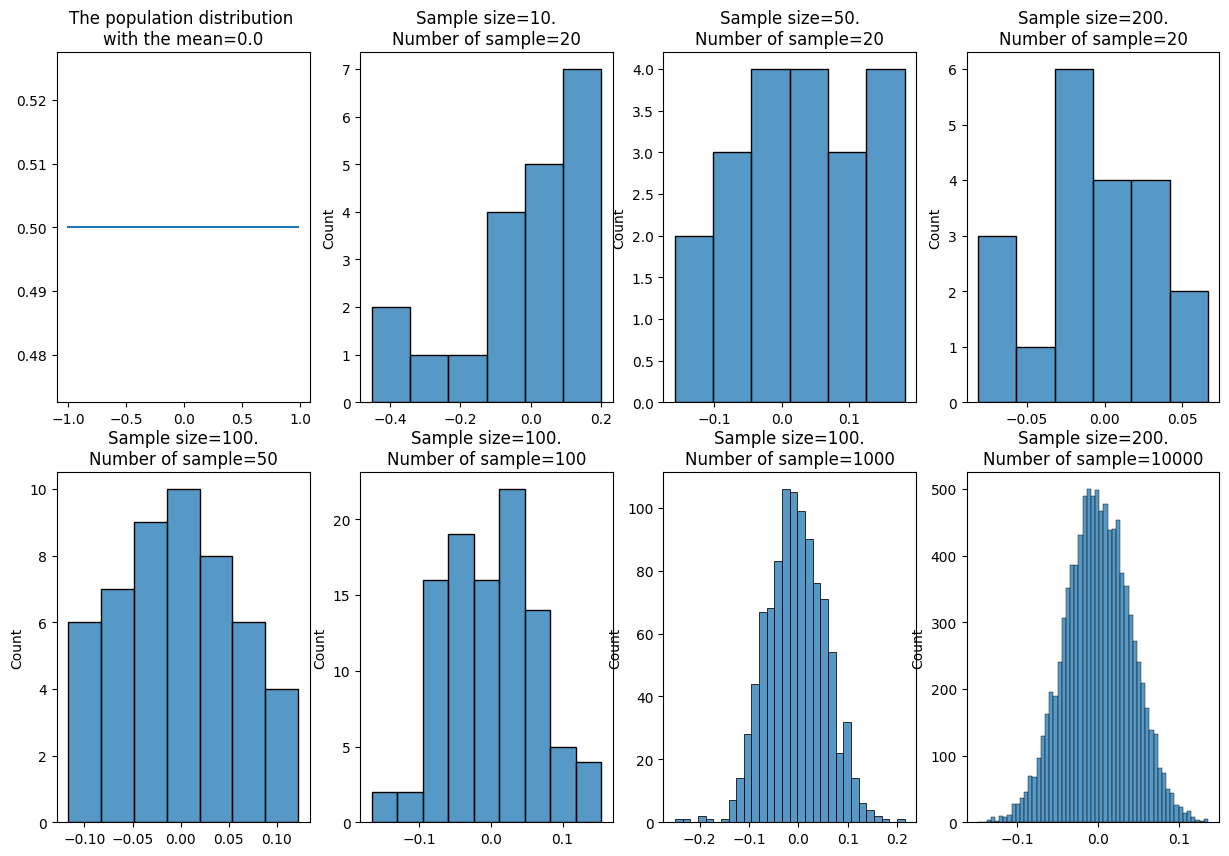

In [ ]:
uniform_distr = uniform(loc=-1, scale=2)
plot_CLT(uniform_distr)

### 3.2. $ \chi^2 $ distribution as the population distribution

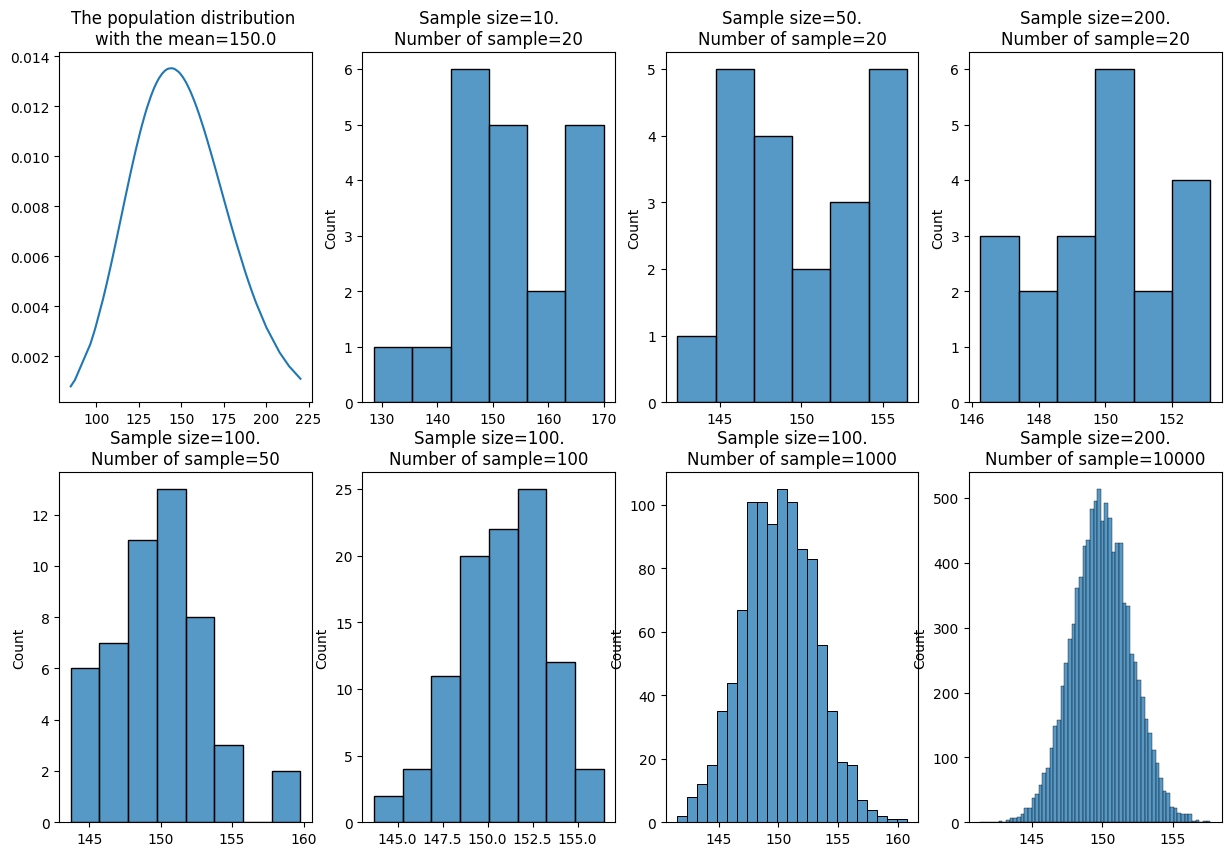

In [ ]:
chi2_distr = chi2(df=50, loc=0, scale=3)
plot_CLT(chi2_distr)

### 3.3. Student t distribution as the population distribution

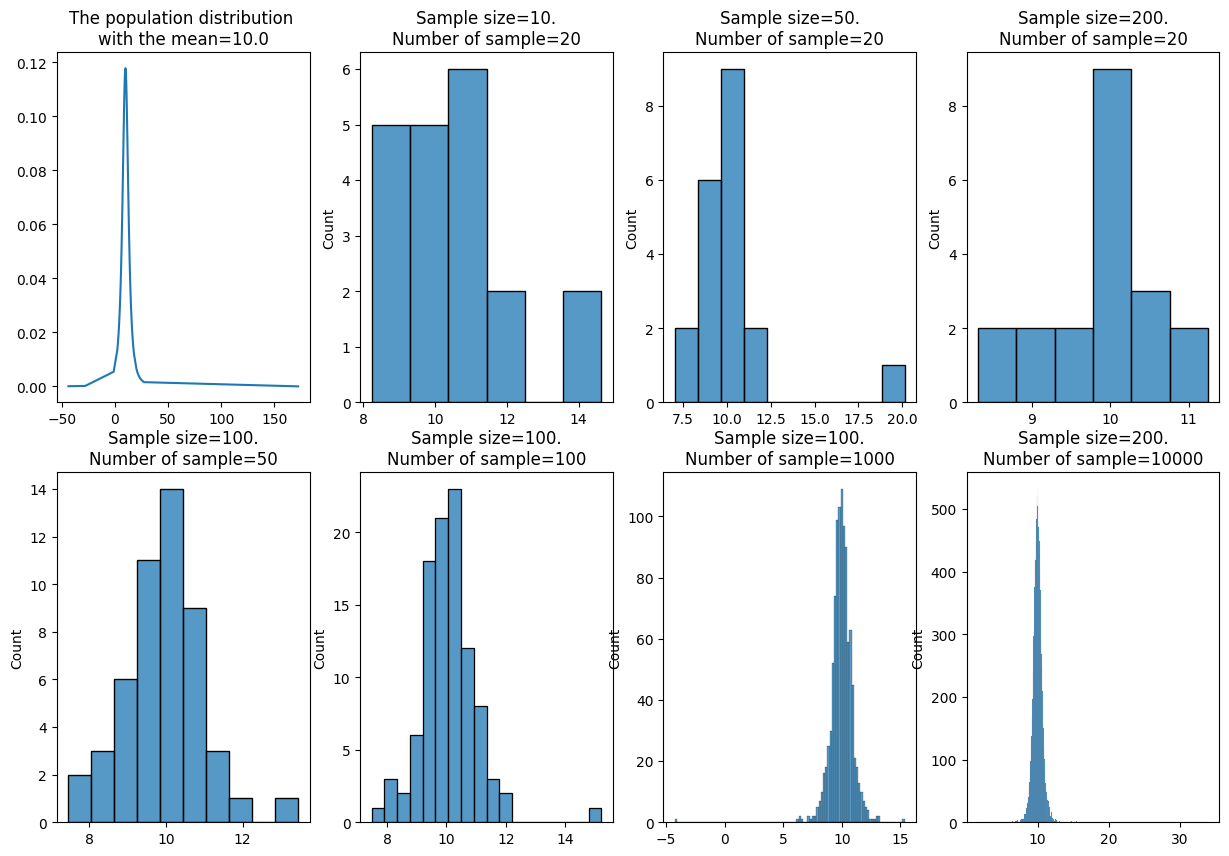

In [ ]:
student_distr = t(df=2, loc=10, scale=3)
plot_CLT(student_distr)

### 3.4. Exponential distribution as the population distribution

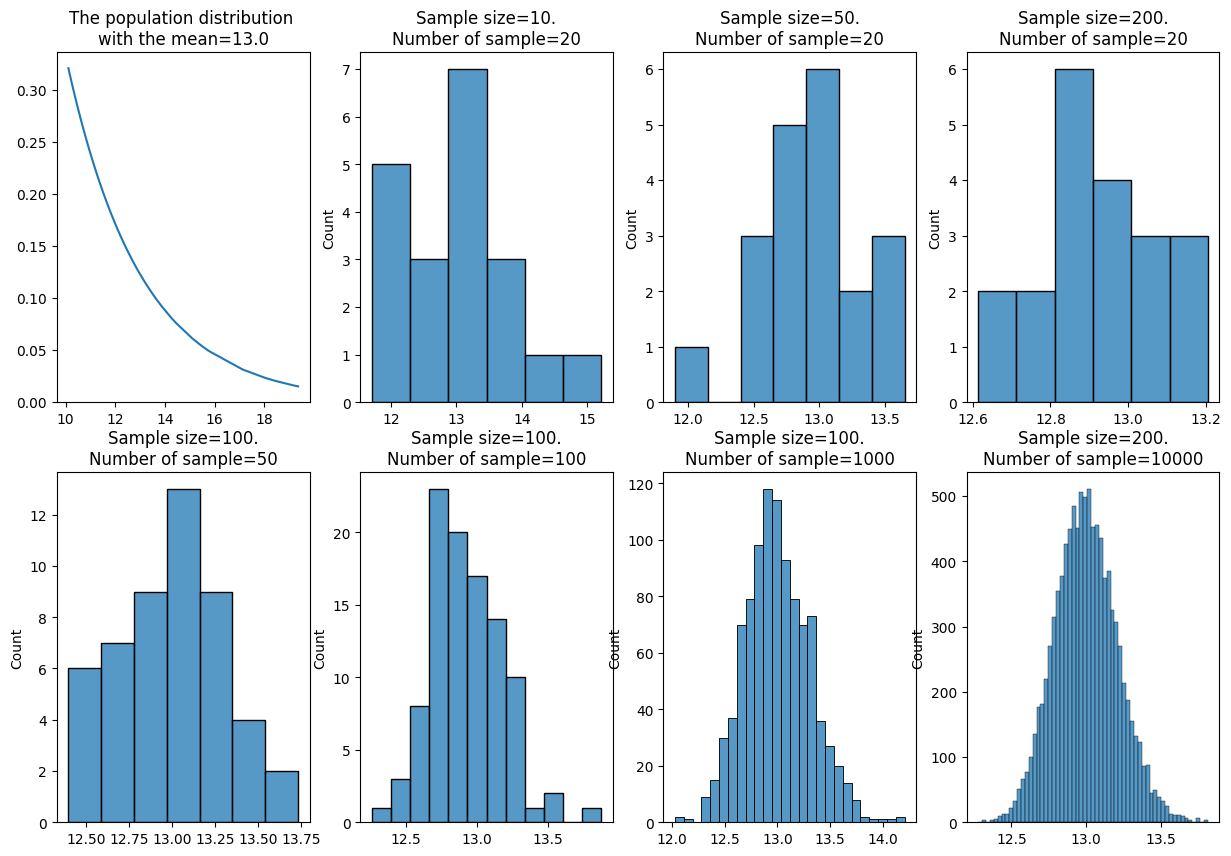

In [ ]:
exp_distr = expon(loc=10, scale=3)
plot_CLT(exp_distr)

### 3.4. Log Normal distribution as the population distribution

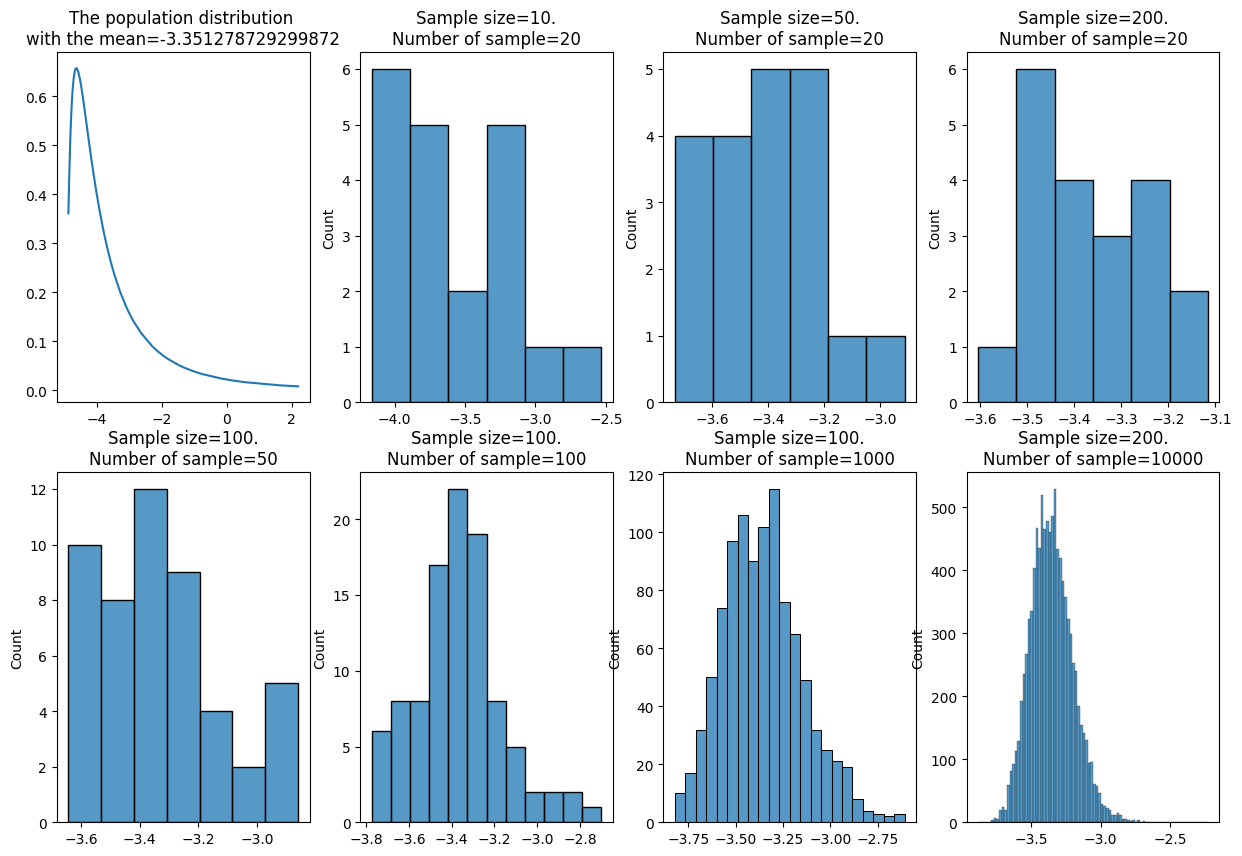

In [ ]:
log_distr = lognorm(s=1, loc=-5, scale=1)
plot_CLT(log_distr)

**Conclusion:** We can see that regardless of the population distribution the sample's distributions of the means are the normal distributions with the mean equal to the population's mean